# Getting started with emu-mps

This tutorial shows how to use emu-mps as a Pulser backend to run a pulse sequence and extract observables (for example, magnetization). We emulate step-by-step the preparation of an antiferromagnetic (AFM) state on a 1D ring of atoms.

For details about this pulse sequence see this [arxiv article](https://arxiv.org/abs/1711.01185).

Let's first import all the needed libraries.

In [1]:
# standard library
from typing import Any
import math

# Pulser and others libraries
import numpy as np
import matplotlib.pyplot as plt
import pulser
from pulser.devices import AnalogDevice

# emu-mps 
from emu_mps import (
    MPS,
    MPSConfig,
    MPSBackend,
    BitStrings,
    Fidelity,
    Occupation,
)

## Pulser and emu-mps

Emu-mps is a Pulser backend, designed to emulate the dynamics of programmable arrays of neutral atoms and here are the steps on how to use it:
1. using Pulser we will first create the atomic Register
2. again with Pulser we will then generate the Pulse sequence that produces the AFM state for the created register
3. we create the configuration object (`MPSConfig`) and we fill it with the needed observables and time step `dt`
4. we instantiate the backend class (`MPSBackend`) and run the simulation
5. we inspect the `results` obtained

### Register and Sequence creation

To keep this tutorial focused on the backend functionalities we use two auxiliary functions to quickly create the Pulser objects like register and the sequence. 

The function `square_perimeter_points` calculates the coordinates of the atoms located on the perimeter of a square. 
The qubits will be labeled starting from the bottom-left corner and moving counter-clockwise around the square. Please notice that the measured bitstrings will depend on the order chosen for the atom locations.

The function `afm_sequence_from_register` creates the pulse sequence for the AFM state for the specified register. The sequence will consist of three phases: a rise, a sweep, and a fall where the sweep time is proportional to the rise and fall times. 

In [2]:
def afm_sequence_from_register(
    reg: pulser.Register,
    Omega_max: float,
    delta_0: float,
    delta_f: float,
    t_rise: int,
    t_fall: int,
    factor_sweep: int,
    device: Any = pulser.devices.MockDevice,
) -> pulser.Sequence:
    """Sequence that creates AntiFerromagnetic State (AFM) for 1d chain of atoms using pulser.
    This function constructs a sequence of pulses to transition a system of qubits
    distributed in a 1D chain (represented by `reg`) into an AFM state using a specified device.
    The sequence consists of three phases: a rise, a sweep, and a fall.
    For more information, check this [arxiv article](https://arxiv.org/abs/1711.01185)."""

    t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000 * factor_sweep
    rise = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )
    sweep = pulser.Pulse.ConstantAmplitude(
        Omega_max, pulser.waveforms.RampWaveform(int(t_sweep), delta_0, delta_f), 0.0
    )
    fall = pulser.Pulse.ConstantDetuning(
        pulser.waveforms.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
    )

    seq = pulser.Sequence(reg, device)
    seq.declare_channel("ising_global", "rydberg_global")
    seq.add(rise, "ising_global")
    seq.add(sweep, "ising_global")
    seq.add(fall, "ising_global")

    return seq


def square_perimeter_points(L: int) -> np.ndarray:
    """
    Calculate the coordinates of the points located on the perimeter of a square of size L.
    The square is centered at the origin (0, 0) with sides parallel to the axes.
    The points are ordered starting from the bottom-left corner and moving
    counter-clockwise around the square. The order is important when measuaring the bitstrings

    Args:
        L (int): The length of the side of the square. L should be a positive integer.

    Returns:
        np.ndarray: An array of shape (4*L-4, 2) containing the coordinates of the perimeter points.

    Example:
        >>> square_perimeter_points(3)
        array([[-1, -1],
               [-1,  0],
               [-1,  1],
               [ 0,  1],
               [ 1,  1],
               [ 1,  0],
               [ 1, -1],
               [ 0, -1]])
    """
    pairOrodd = L % 2
    toGrid = int(math.floor(L / 2))
    if pairOrodd == 0:
        axis = list(range(-toGrid, toGrid, 1))
    else:
        axis = list(range(-toGrid, toGrid + 1, 1))
    coord = []
    for i in axis:  # from left, first column of the perimeter
        coord.append([axis[0], i])

    for i in axis[1:-1]:
        coord.append([i, axis[-1]])

    for i in reversed(axis):
        coord.append([axis[-1], i])

    for i in reversed(axis[1:-1]):
        coord.append([i, axis[0]])

    return np.array(coord)

We define the main physical parameters used throughout the tutorial and recall their meaning:

- `Omega_max`: peak laser amplitude used in the pulse sequence.
- `delta_0`: initial detuning.
- `delta_f`: final detuning.
- `t_rise`: duration of the rise phase.
- `t_fall`: duration of the fall phase.
- `sweep_factor`: scale factor for the sweep duration (proportional to `delta_f - delta_0`).

We choose the interatomic distance to scale with `Omega_max`, so the interaction strengths are relative to the pulse parameters.

In [3]:
Omega_max = 2 * 2 * np.pi
delta_0 = -6 * Omega_max / 2
delta_f = 1 * Omega_max / 2
t_rise = 500
t_fall = 1500
sweep_factor = 2

square_length = 3
R_interatomic = AnalogDevice.rydberg_blockade_radius(Omega_max / 2)

We can now create the register consisting of 8 atom locations.

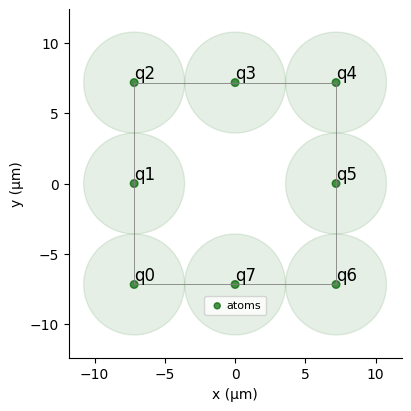

In [4]:
coords = R_interatomic * square_perimeter_points(square_length)
reg = pulser.Register.from_coordinates(coords,prefix='q')
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True)

And finally the pulse sequence that will realize the AFM state:

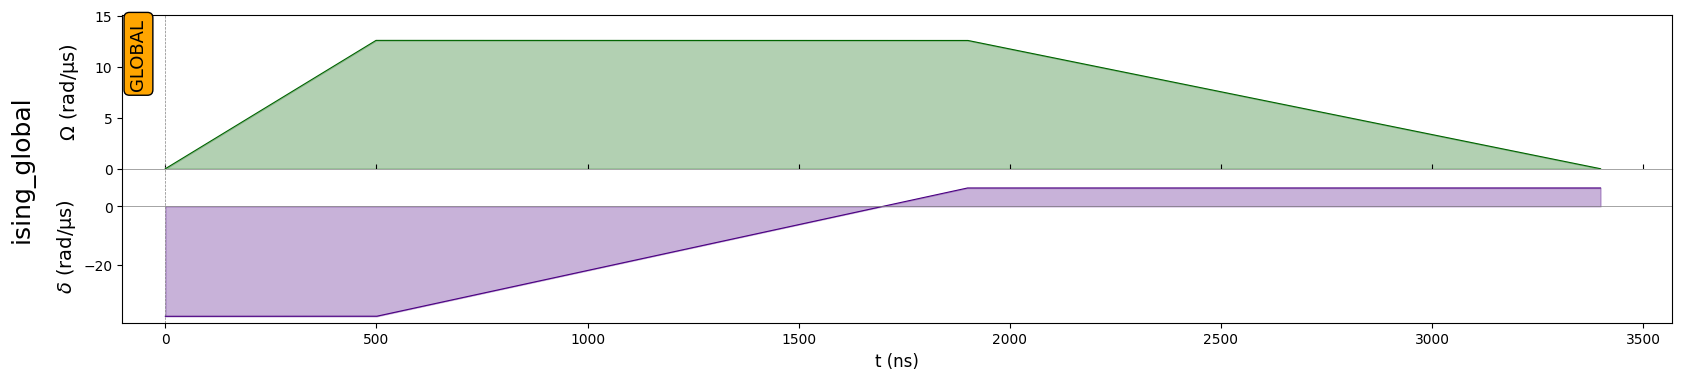

In [5]:
seq = afm_sequence_from_register(
    reg, Omega_max, delta_0, delta_f, t_rise, t_fall, sweep_factor, AnalogDevice
)
seq.draw("input")

### Using emu-mps as backend

As mentioned earlier, to run a simulation with the emu-mps backend we need to provide as input a Pulse sequence - which we have just created - and a configuration object. 

We still have to create the configuration for the emu-mps backend. This is done via an instantiation of the configuration class `MPSConfig` which contains all the observables that we wish to measure and the time step chosen for the simulation, along with various algorithm specific parameters that are explained in the documentation.

We start by setting a bigger discretization time than the default one provided ($dt=10$). For simplicity, we will measure the observables only at the final time of the simulation.

We also fix the basis along which the measurements will be done. For the details regarding the conventions used we refer to the [Pulser documentation](https://pulser.readthedocs.io/en/stable/conventions.html).

In [6]:
dt = 5.0
eval_times = [0.0, 1.0]

basis = ("r","g")

#### BitString counts
It samples the evolved state at desired time steps, returning the *bitStrings* in a counter.

In [7]:
sampling_times = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sampling_times)

#### Fidelity

The *fidelity* is computed as $\langle \psi_{evolved} | \phi_{given} \rangle^2$ where 
- $\psi_{evolved}$ is the system state at desired steps
- $\phi_{given}$ is the state onto which we want to project the system state.

In this tutorial we will compute the fidelity against one of the two dominant antiferromagnetic states $\phi_{given} = |rgrgrgrg>$

In [8]:
nqubits = len(seq.register.qubit_ids)

afm_string_pure = {"rgrgrgrg": 1.0} # |10101010> in ground-rydberg basis

afm_mps_state = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=afm_string_pure
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times, state=afm_mps_state,tag_suffix="1")

#### Occupation of the excited states
It is computed as $\langle \psi_{evolved} |\frac{(1+Z_i)}{2}|\psi_{evolved}\rangle$ and often informally referred to as the *magnetization* at each atom site.

In [ ]:
duration = seq.get_duration()
step = int(dt)
occ_eval_times = [t / duration for t in range(0, duration+step, step)]
density = Occupation(evaluation_times=occ_eval_times)

#### Configuration object for emu-mps

In [10]:
mpsconfig = MPSConfig(
    dt=dt,
    precision=1.0e-9,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
    ],
    log_level=10,
)

emu-mps allows only {'energy', 'energy_variance', 'occupation', 'bitstrings', 'energy_second_moment', 'correlation_matrix', 'statistics'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity'} using `optimize_qubit_ordering = False` instead.


### Finally, we run 

We instantiate the backend and run the simulation. The `MPSBackend` class takes the `sequence` and `config` objects as arguments.

In [11]:
sim = MPSBackend(seq, config=mpsconfig)
results = sim.run()

emu-mps allows only {'energy', 'energy_variance', 'occupation', 'bitstrings', 'energy_second_moment', 'correlation_matrix', 'statistics'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity'} using `optimize_qubit_ordering = False` instead.
Will save simulation state to file "emu_mps_save_1ce42ea0-faa7-11f0-a0dd-b6cf08f1a91f.dat"
            every inf seconds.
To resume: `MPSBackend().resume("/Users/kemal/Programs/Pasqal/emuteam/Stefano/emulators/docs/emu_mps/notebooks/emu_mps_save_1ce42ea0-faa7-11f0-a0dd-b6cf08f1a91f.dat")`
step = 1/680, χ = 1, |ψ| = 0.000 MB, RSS = 372965.376 MB, Δt = 0.044 s
step = 2/680, χ = 3, |ψ| = 0.001 MB, RSS = 372981.760 MB, Δt = 0.016 s
step = 3/680, χ = 3, |ψ| = 0.001 MB, RSS = 372981.760 MB, Δt = 0.019 s
step = 4/680, χ = 4, |ψ| = 0.002 MB, RSS = 372998.144 MB, Δt = 0.020 s
step = 5/680, χ = 4, |ψ| = 0.002 MB, RSS = 373014.528 MB, Δt = 0.020 s
step = 6/680, χ = 3, |ψ| = 0.001 MB, RSS = 373047.296 MB, Δt = 0.023 s
step = 7

## Inspecting the result object

In the following lines, we are going to give brief code examples of how you can get the information from the results object

In [12]:
results.get_result_tags()

['bitstrings', 'fidelity_1', 'occupation', 'statistics']

Notice that `fidelity_1` name contains the subindex `_1` according to the `tag_suffix="1"`, because it is possible to create several fidelities on different states, and the names must be unique.

#### Computation statistics

During the simulation the sequence is discretized into steps according to `dt`. For each step `results.statistics` contains:
- $\chi$: maximum bond dimension used.
- $|\Psi|$: MPS memory footprint.
- RSS: peak memory allocation.
- Δt: wall-clock time for that step.

Example:

In [13]:
# print statistics of step 1
statistics = results.statistics
print(f"Number of discretized steps:\n {len(statistics)}")
print("Step 1 statistics\n",statistics[1])

Number of discretized steps:
 680
Step 1 statistics
 {'max_bond_dimension': 3, 'memory_footprint': 0.000736, 'RSS': 372981.76, 'duration': 0.016418933868408203}


#### Bitstrings analysis

Below, we retrieve the bitstrings computed.
We observe that they were indeed computed only at a single time $ns = 3400$, and we find those that were sampled the highest number of times with their relative counting.

The most frequent bitstring is ['10101010'] which was sampled 282 times


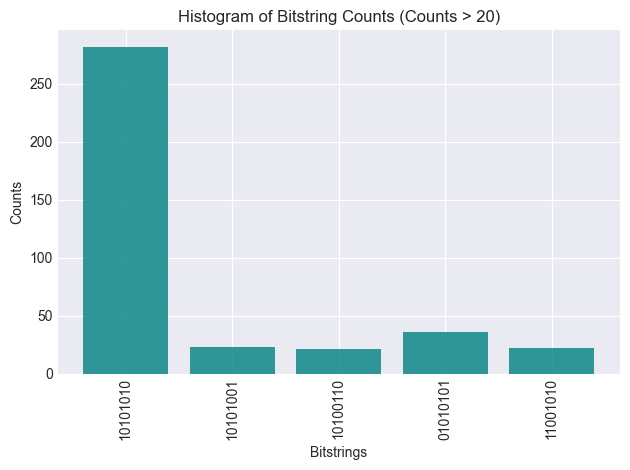

In [14]:
results.get_result_times(bitstrings)
bitstrings_final = results.get_result(bitstrings, 1.0)

max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 20]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 20
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

#### Fidelity analysis

Here we compute the fidelity of the system against the two different AFM state realizations defined above.  

In [15]:
fidelity_pure = results.get_result(fidelity_mps_pure, 1.0)

print(
    "The probability of the system being in the sate |rgrgrgr> is equal to {} ".format(
        fidelity_pure,
    )
)

The probability of the system being in the sate |rgrgrgr> is equal to 0.24778655760582485 


### Evolution of the state in time

Here, we plot the time evolution of the magnetization of the system sites, and we observe how the system slowly reaches the AFM state.

In [16]:
magnetization_values = np.array(list(results.occupation))
magnetization_times = results.get_result_times(density) 

In [17]:
# rescaling the time
real_times = []
for time in magnetization_times:
    real_times.append(time * seq.get_duration())

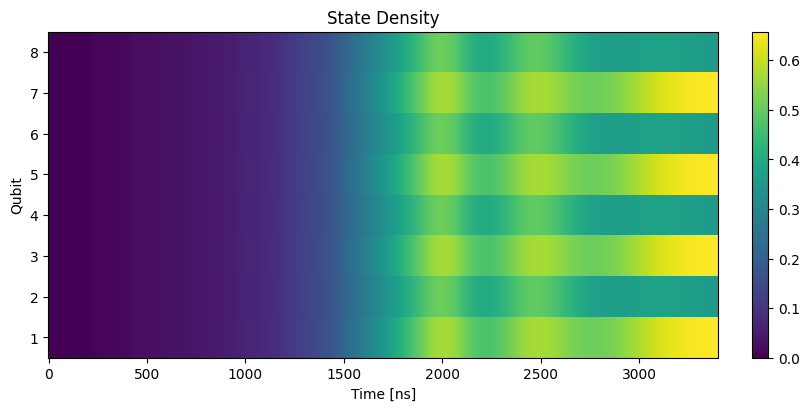

In [18]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(real_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)